In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import opt_einsum   

In [6]:
def torch_repeat(x, repeats, axis=None):
    """
    PyTorch equivalent of np.repeat.

    Parameters
    ----------
    x : torch.Tensor
        Input tensor.
    repeats : int or 1D list/Tensor of ints
        Number of repetitions.
    axis : int or None
        Dimension along which to repeat. If None, the tensor is flattened.

    Returns
    -------
    torch.Tensor
    """

    # Match NumPy: if axis is None, flatten first
    if axis is None:
        x = x.flatten()
        return torch.repeat_interleave(x, repeats)

    # Normalize negative axes
    if axis < 0:
        axis += x.dim()

    # Move target axis to the end
    x = x.transpose(axis, -1)

    # Apply repeat_interleave on last dimension
    out = torch.repeat_interleave(x, repeats, dim=-1)

    # Move axis back
    out = out.transpose(axis, -1)

    return out

In [7]:
class BSplineBasis:
    """
    B-spline basis functions with vectorized evaluation and differentiation using PyTorch.

    Attributes:
        N (int): Number of basis functions.
        p (int): Degree of the B-splines.
        C (int): Continuity at internal knots (C < p).
        t (torch.Tensor): Knot vector.
        L (float): Scaling to parent domain [0,L].
        Dx (float): Translation to parent domain if needed.
        dtype (torch.dtype): Torch data type for computations.
        device (torch.device): Torch device for computations.
    """
    def __init__(self, N, p, C, dtype, device):
        """""
        Initialize the B-spline basis.

        Args:
            N: Number of basis functions.
            p: Degree of the B-splines.
            C: Continuity at internal knots (C < p).
            dtype: Torch data type for computations.
            device: Torch device for computations.
        """
        super().__init__()
        self.dtype = dtype
        self.device = device
        self.N = N
        self.L = 1.0  # Scaling to parent domain [0,L]
        self.Dx = 0 # Translation to parent domain if needed
        self.p = p
        self.C = C
        # Knot vector
         # Repeated knots at start
        self.t = torch.zeros(self.p+1, dtype=self.dtype, device=self.device)
        # Equally spaced internal knots with multiplicity (p - C)
        self.t = torch.cat((
            self.t,
            torch_repeat(
                torch.linspace(
                    0, 1,
                    int((self.N - self.p - 1)/(self.p - self.C)) + 2,
                    dtype=self.dtype, device=self.device
                )[1:-1],
                self.p - self.C
            )
        ))
        # Repeated knots at end
        self.t = torch.cat((self.t, torch.ones(self.p+1, dtype=self.dtype, device=self.device)))
        # Set tolerances based on dtype
        if self.dtype == torch.float32:
            self.rtol, self.atol = 1e-5, 1e-7
        if self.dtype == torch.float64:
            self.rtol, self.atol = 1e-13, 1e-15

    def to(self, dtype, device):
        self.__init__(self.N, self.p, self.C, dtype, device)

    def _basis_dp(self, x: torch.Tensor, p: int) -> torch.Tensor:
        """
        Vectorized Cox–de Boor evaluation for all basis functions in parallel.

        Args:
            x: 1D tensor of evaluation points, shape (Q,).
            return_prev: If True, also returns I_{*,p-1}(x) for derivative.

        Returns:
            I_p: (N, Q) values of I_{i,p}(x).
            I_pm1: (N, Q) values of I_{i,p-1}(x) if return_prev=True, else None.
        """
        # ------------------------------------------------------
        # Degree 0 basis: indicator functions:
        #
        #   I_{i,0}(x) = 1  if  t_i ≤ x < t_{i+1}
        #                0  otherwise
        #
        # This produces an (N,Q) boolean tensor.
        # ------------------------------------------------------
        t_i = self.t[:self.N].unsqueeze(1)       # (N,1)
        t_ip1 = self.t[1:self.N+1].unsqueeze(1)  # (N,1)
        # Use half-open intervals [t_i, t_{i+1})
        I = (t_i <= x) & (x < t_ip1)  # (N,Q) boolean
        # Right-clamping allows the last basis to include x == t_{N+p+1}
        at_right_endpoint = torch.isclose(x, t_ip1[-1], rtol=self.rtol, atol=self.atol)
        # Left-clamping for first basis function
        I[-1] = I[-1] | at_right_endpoint
        
        # If degree is zero, stop here.
        if p == 0:
            return I

        # ------------------------------------------------------
        # Cox–de Boor recurrence:
        #
        #     I_{i,r}(x) = w1 * I_{i,r-1}(x)  +  w2 * I_{i+1,r-1}(x)
        #
        # where
        #
        #     w1 = (x - t_i) / (t_{i+r}   - t_i)
        #     w2 = (t_{i+r+1} - x) / (t_{i+r+1} - t_{i+1})
        #
        # Vectorization strategy:
        #   - I has shape (N,Q) for degree r-1
        #   - I_ip1 is I shifted by one index
        # ------------------------------------------------------
        for r in range(1, p+1):
            # denominators of the weights for degree r
            den1 = (self.t[r:r+self.N] - self.t[:self.N]).unsqueeze(1)          # (N,1)
            den2 = (self.t[r+1:r+1+self.N] - self.t[1:self.N+1]).unsqueeze(1)   # (N,1)

            # Shift basis upward in i-index: I_{i+1, r-1}
            # Last row is zero (no basis above index N-1)
            I_ip1 = torch.cat([I[1:], torch.zeros_like(I[:1])], dim=0)

            # Weights of the Cox-de Boor recursion with safe division
            w1 = torch.where(den1 > 0, (x - self.t[:self.N].unsqueeze(1)) / den1, torch.zeros_like(I))
            w2 = torch.where(den2 > 0, (self.t[r+1:r+1+self.N].unsqueeze(1) - x) / den2, torch.zeros_like(I))

            # Apply Cox–de Boor recurrence
            I = w1 * I + w2 * I_ip1

        # return basis of degree p
        return I

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate all B-spline basis functions I_{i,p}(x) in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).

        Returns:
            (B=1, N, Q) tensor with I_{i,p}(x).
        """
        # Scale x to parent domain
        x = (x - self.Dx) / self.L
        # Compute basis functions
        output = self._basis_dp(x, self.p)
        # Add batch dimension
        output = output[None,:,:]
        return output
    
    def derivative(self, x: torch.Tensor, n: int) -> torch.Tensor:
        """
        Evaluate n-th derivatives d^n/dx^n I_{i,p}(x) for all i in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).
            n: Order of the derivative.

        Returns:
            (B, N, Q) tensor with d^n/dx^n I_{i,p}(x).
        
        Notes:
            Uses the known B-spline derivative formula:
            d/dx I_{i,p}(x)
            = p/(t_{i+p} - t_i) * I_{i,p-1}(x)
            - p/(t_{i+p+1} - t_{i+1}) * I_{i+1,p-1}(x)
        """
        # Scale x to parent domain
        x = (x - self.Dx) / self.L

        # Select starting basis functions I_{*, p-n}
        dI = self._basis_dp(x, self.p - n)
        # Set polynomial degree for first iteration (order of starting basis functions + 1)
        p_temp = self.p - n + 1
        # Iteratively apply derivative formula n times on starting basis functions
        for k in range(n):
            # Compute weights
            den1 = (self.t[p_temp:p_temp+self.N] - self.t[:self.N]).unsqueeze(1)
            den2 = (self.t[p_temp+1:p_temp+1+self.N] - self.t[1:self.N+1]).unsqueeze(1)
            w1 = torch.where(den1 > 0, p_temp / den1, torch.zeros_like(dI))
            w2 = torch.where(den2 > 0, p_temp / den2, torch.zeros_like(dI))
            # Shift basis upward in i-index: I_{i+1, p_temp-1}
            dI_ip1 = torch.cat([dI[1:], torch.zeros_like(dI[:1])], dim=0)
            # Update derivative
            dI = w1 * dI - w2 * dI_ip1
            # Increase temporary polynomial degree
            p_temp += 1
        # Final derivative
        output = dI
        # Add batch dimension
        output = output[None,:,:]
        # Scale derivative back to original domain
        output = output / (self.L ** n)
        return output
    
    def grad(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate derivatives d/dx I_{i,p}(x) for all i in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).

        Returns:
            (B, N, Q) tensor with d/dx I_{i,p}(x).
        """
        return self.derivative(x, n=1)  

    def laplacian(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate second derivatives d^2/dx^2 I_{i,p}(x) for all i in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).

        Returns:
            (B, N, Q) tensor with d^2/dx^2 I_{i,p}(x).
        """
        return self.derivative(x, n=2)

In [8]:
x = torch.linspace(0, 1, 1001, dtype=torch.float64, device='cuda')

In [9]:
basis = BSplineBasis(N=10, p=3, C=2, dtype=torch.float64, device='cuda')

In [10]:
basis.t

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143,
        0.8571, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       dtype=torch.float64)

In [11]:
basis.forward(x).shape

torch.Size([1, 10, 1001])

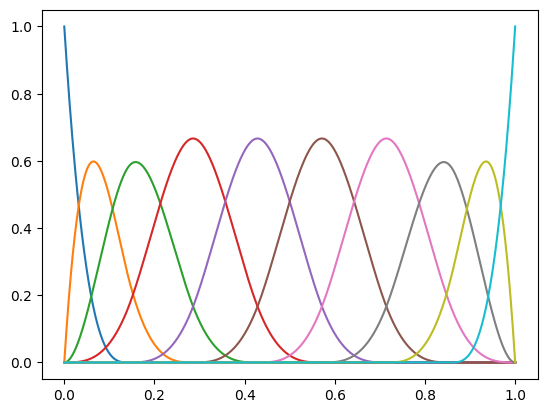

In [12]:
for i in range(basis.N):
    plt.plot(x.cpu(), basis.forward(x)[0,i, :].cpu(), label=f'N_{i},{basis.p}')
    # plt.plot(x.cpu(), y2[0,i, :].cpu(), label=f'N_{i},{basis2.p}')

In [13]:
basis.grad(x).shape

torch.Size([1, 10, 1001])

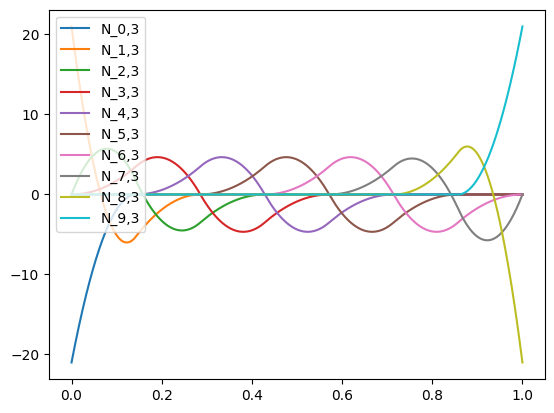

In [ ]:
for i in range(basis.N):
    plt.plot(x.cpu(), basis.grad(x)[0,i, :].cpu(), label=f'N_{i},{basis.p}')
plt.legend()

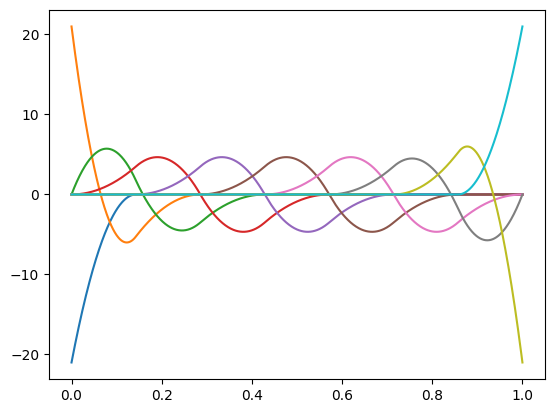

In [15]:
grad = basis.derivative(x, n=1).cpu().numpy()

for i in range(basis.N):
    plt.plot(x.cpu(), grad[0,i, :], label=f'N_{i},{basis.p}')
    # plt.plot(x.cpu(), y2[0,i, :].cpu(), label=f'N_{i},{basis2.p}')



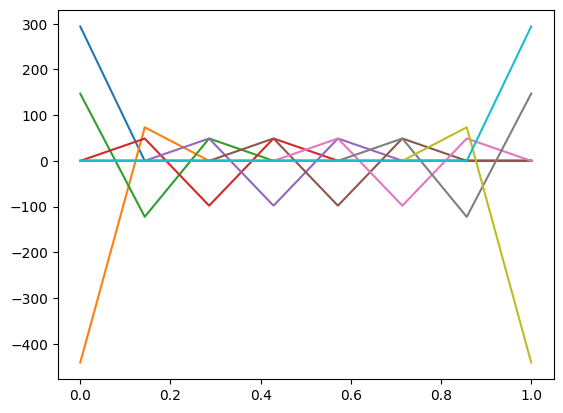

In [17]:
d2 = basis.derivative(x, n=2).cpu().numpy()

for i in range(basis.N):
    plt.plot(x.cpu(), d2[0,i, :], label=f'N_{i},{basis.p}')
    # plt.plot(x.cpu(), y2[0,i, :].cpu(), label=f'N_{i},{basis2.p}')

